In [1]:
import numpy as np
import seaborn as sns
from tqdm import tqdm

from CRDDM.Models import SDM

import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution as DE

# 1) Fixed threshold:

## 1.1) Simulation:

In [2]:
threshold = 3
drift_vector = np.array([2, 2, 2])
ndt = 0.3

sdm = SDM.FixedThresholdSDM()

df = sdm.simulate(threshold, drift_vector, ndt, n_sample=10000)

In [3]:
df

,rt,response1,response2
0,0.960,1.544484,0.321835
1,1.089,1.084000,0.608946
2,1.152,1.333840,0.393516
3,0.987,0.581935,1.100609
4,1.180,0.738583,1.072259
...,...,...,...
9995,1.152,0.468830,0.293543
9996,0.931,1.305467,1.015196
9997,1.373,0.645691,-0.080005
9998,0.949,0.722203,0.082726


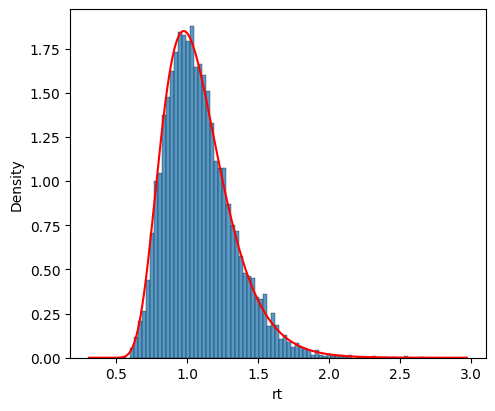

In [5]:
plt.figure(figsize=(9, 4), layout='constrained')
plt.subplot(121)
t = np.linspace(0.01, df['rt'].max(), 200)
plt.plot(t+ndt, sdm.response_time_pdf(t, threshold, drift_vector), color='red')
sns.histplot(df['rt'], stat='density');

# plt.subplot(122)
# theta = np.linspace(-3.14, 3.14, 200)
# plt.plot(theta, SDM.response_pdf(theta, threshold, drift_vector), color='red')
# sns.histplot(df['response'], stat='density');

# Parameter recovery:

In [5]:
def fit_cdm(prms, rt, theta):
    threshold =  prms[0] # decision threshold
    ndt = prms[1] # non-decision time
    drift_vec = np.array([prms[2], prms[3], prms[4]]) # drift vector
    s_v = 0 #prms[4]
    
    return -np.sum(SDM.joint_lpdf(rt, theta, threshold, drift_vec, ndt, s_v=s_v))

In [6]:
n_trials = 300
recovery_df = {'threshold_true': [],
               'threshold_estimate': [],
               'ndt_true': [],
               'ndt_estimate': [],
               'mu_x_true': [],
               'mu_x_estimate': [],
               'mu_y_true': [],
               'mu_y_estimate': [],
               'mu_z_true':[],
               'mu_z_estimate': []}

# These are the bounds for parameter estimation
min_threshold = 0.05
max_threshold = 5

min_ndt = 0
max_ndt = 2

min_mu = -5
max_mu = 5

prms_bounds = [(min_threshold, max_threshold), (min_ndt, max_ndt),
               (min_mu, max_mu), (min_mu, max_mu), (min_mu, max_mu)]

In [7]:
for n in tqdm(range(100)):
    # generating some random parameters
    threshold = np.random.uniform(0.5, max_threshold)
    mu_x = np.random.uniform(min_mu, max_mu)
    mu_y = np.random.uniform(min_mu, max_mu)
    mu_z = np.random.uniform(min_mu, max_mu)
    drift_vector = np.array([mu_x, mu_y, mu_z])
    ndt = np.random.uniform(0.05, max_ndt)
    
    sim_df = SDM.rng(threshold, drift_vector, ndt, s_v=0, n_sample=n_trials)
    
    # Estimating the paramters for the simulated data
    min_ans = DE(fit_cdm, args=(sim_df['rt'].values, sim_df[['response1', 'response2']].values), 
                 bounds=prms_bounds)

    
    # Storing the true generating parameters
    recovery_df['threshold_true'].append(threshold)
    recovery_df['ndt_true'].append(ndt)
    recovery_df['mu_x_true'].append(mu_x)
    recovery_df['mu_y_true'].append(mu_y)
    recovery_df['mu_z_true'].append(mu_z)
    
    # Stroing the estimated parameters
    recovery_df['threshold_estimate'].append(min_ans.x[0])
    recovery_df['ndt_estimate'].append(min_ans.x[1])
    recovery_df['mu_x_estimate'].append(min_ans.x[2])
    recovery_df['mu_y_estimate'].append(min_ans.x[3])
    recovery_df['mu_z_estimate'].append(min_ans.x[4])

100%|█████████████████████████████████████████| 100/100 [02:20<00:00,  1.40s/it]


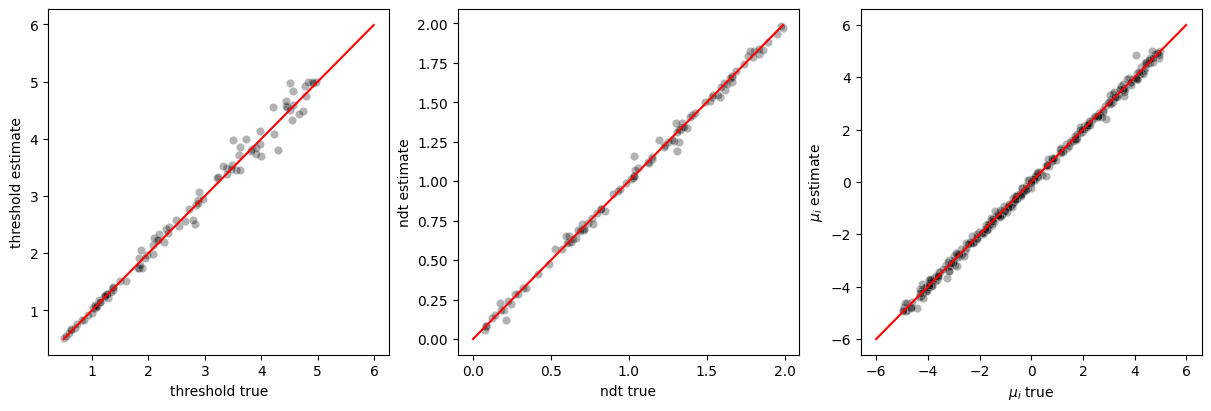

In [8]:
plt.figure(figsize=(12, 4), layout='constrained')

plt.subplot(131)
plt.plot(np.arange(.5, 6, 0.01), np.arange(.5, 6, 0.01), c='red')
sns.scatterplot(x='threshold_true', y='threshold_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'threshold true')
plt.ylabel(r'threshold estimate')

plt.subplot(132)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'ndt true')
plt.ylabel(r'ndt estimate')

plt.subplot(133)
plt.plot(np.arange(-6, 6, 0.01), np.arange(-6, 6, 0.01), c='red')
sns.scatterplot(x='mu_x_true', y='mu_x_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_y_true', y='mu_y_estimate', data=recovery_df, color='black', alpha=0.3);
sns.scatterplot(x='mu_z_true', y='mu_z_estimate', data=recovery_df, color='black', alpha=0.3);
plt.xlabel(r'$\mu_i$ true')
plt.ylabel(r'$\mu_i$ estimate');


# 2) Collapsing threshold:

## 2.1) Simulation:

In [2]:
threshold = 3
decay = 0.7
drift_vector = np.array([2, 1, 0])
ndt = 0.3

model = SDM.CollapsingThresholdSDM()

df = model.simulate(threshold, 
                    decay, 
                    drift_vector, 
                    ndt, 
                    n_sample=10000)

In [3]:
df

,rt,response1,response2
0,1.106,1.353526,1.803312
1,0.671,0.483563,0.432289
2,1.207,1.483370,-0.348508
3,1.110,1.173868,1.194016
4,0.810,0.668370,-0.821704
...,...,...,...
9995,1.713,0.799759,-0.473404
9996,0.809,0.899051,0.125614
9997,0.891,0.933337,0.045724
9998,0.946,0.408691,0.131015


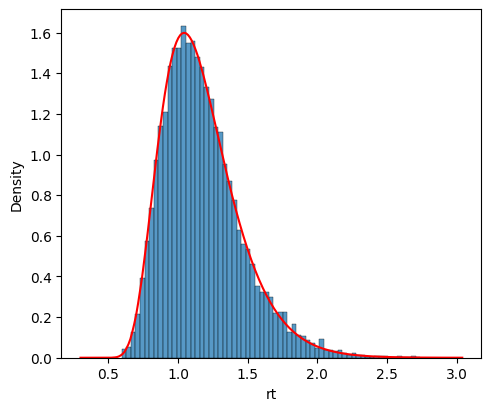

In [5]:
plt.figure(figsize=(9, 4), layout='constrained')
plt.subplot(121)
t = np.linspace(0, df['rt'].max(), 200)
plt.plot(t+ndt, model.response_time_pdf(t, threshold, decay, drift_vector), color='red')
sns.histplot(df['rt'], stat='density');